In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import OffManifoldLearning.globals as gl
import os

plt.style.use('default')

# Basis vectors

We simulated an experiment in which two groups of participants (stroke and controls; N=20 in each group) are assessed
using a device that can record isometric finger forces in three different directions (X, Y, Z), similar to the Hand Articulation
Neuro-training Device (HAND) ([Carducci et al., 2022](https://www.mdpi.com/1424-8220/22/19/7441)). The motor
repertoire of the two groups was simulated through a set of 36 basis vectors, including: (1) 15 single-finger
synergies, i.e., one per finger and movement direction; (2) 20 multi-finger synergies; (3) a flexion/extension
 bias with the same weight in the X direction of each finger. The latter component was designed to simulate the
 flexor bias previously observed both in stroke patients and control participants
 ([Xu et al., 2023](https://www.biorxiv.org/content/10.1101/2023.08.29.555444v1)). Single-finger synergies were
 strong in controls and weak in stroke patients, simulating the loss of fine finger control. On the other hand, the
 flexion bias was strong in patients and week in controls.

In [2]:
dataset = ['stroke', 'intact']
tinfo = pd.read_csv(os.path.join(gl.baseDir, 'baseline', 'tinfo.tsv'), sep='\t')
medianB = tinfo[tinfo.group=='stroke'].w_b.median()
tinfo['severity'] = 'mild'
tinfo.loc[tinfo.w_b < medianB, 'severity'] = 'severe'
N = len(tinfo.subj_id.unique())

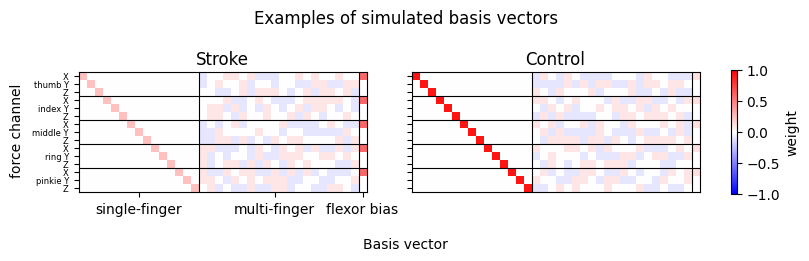

In [35]:
sn = 105
A_i = np.load(os.path.join(gl.baseDir, 'baseline', f'basis_vectors.intact.{sn}.npy'))
A_s = np.load(os.path.join(gl.baseDir, 'baseline', f'basis_vectors.stroke.{sn}.npy'))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 2.5], sharex=True, sharey=True)
axs[1].imshow(A_i, vmin=-1, vmax=1, cmap='bwr')
axs[0].imshow(A_s, vmin=-1, vmax=1, cmap='bwr')
axs[0].set_title('Stroke')
axs[1].set_title('Control')
axs[0].set_xticks([7, 24, 35])
axs[0].set_xticklabels(['single-finger', 'multi-finger', 'flexor bias'],)
axs[1].tick_params(bottom=False, labelbottom=False)
axs[0].set_yticks(np.arange(0, A_i.shape[0]))
axs[0].set_yticklabels(gl.channels, fontsize=6)
for ax in axs:
    for i in [2.5, 5.5, 8.5, 11.5]:
        ax.axhline(i, color='k', lw=.8)
    for i in [14.5, 34.5]:
        ax.axvline(i, color='k', lw=.8)

cax = axs[0].get_images()[0]
cbar = fig.colorbar(cax, ax=axs, orientation='vertical', fraction=.01)
cbar.set_label('weight')

fig.supxlabel('Basis vector', fontsize=10)
fig.supylabel('force channel', fontsize=10)

fig.suptitle('Examples of simulated basis vectors')

plt.show()

# Pre-rehabilitation assessment of finger individuation

Starting from the basis vectors, we simulated an experiment similar to [Xu et al., 2023](https://www.biorxiv.org/content/10.1101/2023.08.29.555444v1), in which participants attempted to perform single-finger movements in
 X, Y, Z directions. As show in the example below, simulated control participants showed better individuation than
 stroke patients.

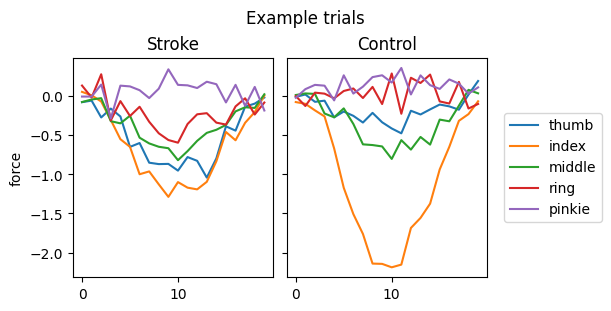

In [5]:
X_i = np.load(os.path.join(gl.baseDir, 'baseline', f'single_finger.pretraining.intact.{sn}.npy'))
X_s = np.load(os.path.join(gl.baseDir, 'baseline', f'single_finger.pretraining.stroke.{sn}.npy'))
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=[6, 3])
tr = 6
axs[0].plot(X_s[tr, ::5, ::3])
axs[1].plot(X_i[tr, ::5, ::3])
axs[0].set_ylabel('force')
axs[0].set_title('Stroke')
axs[1].set_title('Control')
axs[1].legend(['thumb', 'index', 'middle', 'ring', 'pinkie'], bbox_to_anchor=(1.05, .5), loc='center left')
fig.suptitle('Example trials')
plt.show()

In [6]:
euc = np.zeros((2, N, 5, 6, 6)) # (groups, n_subj, n_finger, dir, dir)
cos = np.zeros_like(euc)
for d, ds in enumerate(dataset):
    for f, fi in enumerate(tinfo.finger.unique()):
        for s, sn in enumerate(tinfo.subj_id.unique()):
            tinfo_s = tinfo[(tinfo.subj_id == sn) & (tinfo.group == ds)]
            X = np.load(os.path.join(gl.baseDir, 'baseline', f'single_finger.pretraining.{ds}.{sn}.npy')) # (trials, time, channels)
            X_f = X[tinfo_s.finger == f, 50] #.mean(axis=1)
            X_m = X_f.reshape(6, -1, 15).mean(axis=1)
            G = X_m @ X_m.T
            diag = np.diag(G)
            norm = np.sqrt(np.outer(diag, diag))
            D2 = diag[:, None] + diag[None, :] - 2 * G
            euc[d, s, f] = np.sqrt(D2)
            cos[d, s, f] = 1 - G / norm

We then assessed the Euclidean and cosine distance between force patterns produced by the two groups during
single-finger movements. In line with [Xu et al., 2023](https://www.biorxiv.org/content/10.1101/2023.08.29.555444v1),
 stroke patients showed larger Euclidean distance, likely reflecting the strong bias acting in the flexion/extension
 direction. On the other hand, the cosine distance was larger in controls, consistent with their richer motor
 repertoire.

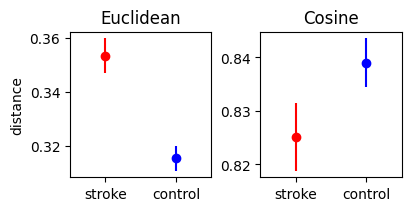

In [8]:
tinfo_g = tinfo.groupby(['subj_id', 'group', 'severity']).mean(numeric_only=True).reset_index()
w_b_s = tinfo_g[tinfo_g['group'] == 'stroke'].w_b.to_numpy()
w_b_i = tinfo_g[tinfo_g['group'] == 'intact'].w_b.to_numpy()

euc_p = euc.mean(axis=(2, 3, 4))
euc_avg = euc_p.mean(axis=1)
euc_err = euc_p.std(axis=1) / np.sqrt(N)
cos_p = cos.mean(axis=(2, 3, 4))
cos_avg = cos_p.mean(axis=1)
cos_err = cos_p.std(axis=1) / np.sqrt(N)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=[4, 2], sharex=True)

axs[0].errorbar(['stroke'], euc_avg[0], yerr=euc_err[0], fmt='o', color='r')
axs[0].errorbar(['control'], euc_avg[1], yerr=euc_err[1], fmt='o', color='b')
axs[0].set_title('Euclidean')
axs[0].set_ylabel('distance')
axs[1].errorbar(['stroke'], cos_avg[0], yerr=euc_err[0], fmt='o', color='r')
axs[1].errorbar(['control'], cos_avg[1], yerr=euc_err[1], fmt='o', color='b')
axs[1].set_xlim(-.5, 1.5)
axs[1].set_title('Cosine')

plt.show()

Euclidean, stroke, slope=1.516, r=0.458, p=0.042
Euclidean, control, slope=1.082, r=0.226, p=0.338
Cosine, stroke, slope=0.417, r=0.164, p=0.489
Cosine, control, slope=0.063, r=0.017, p=0.942


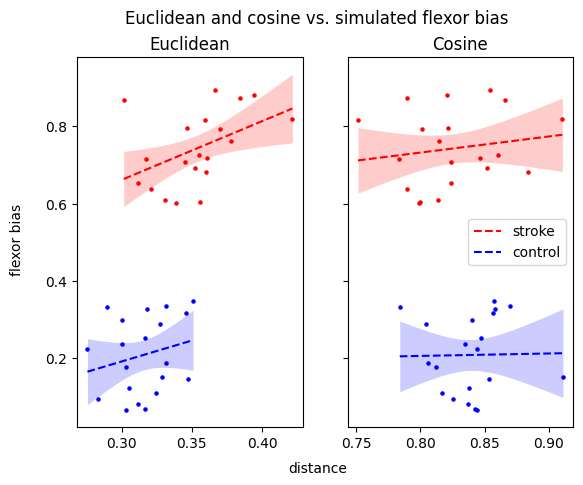

In [22]:
from scipy.stats import t, linregress

fig, axs = plt.subplots(1, 2, sharey=True)

dist = np.vstack([euc_p, cos_p])
w_b = np.vstack([w_b_s, w_b_i])
color = ['r', 'b']
title = ['Euclidean', 'Cosine']
label = ['stroke', 'control']
for p in range(dist.shape[0]):
    ax = axs[p // 2]
    x = dist[p]
    g = p % 2
    y =  w_b[g]
    c = color[g]
    l = label[g]
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = slope * x_fit + intercept

    # Compute confidence intervals
    n = len(x)
    y_pred = slope * x + intercept
    residuals = y - y_pred
    dof = n - 2
    t_val = t.ppf(0.95, dof)

    se_line = np.sqrt(np.sum(residuals ** 2) / dof * (1 / n + (x_fit - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)))
    ci = t_val * se_line

    # Check confidence interval at x = 0
    ix_0 = np.argmin(np.abs(x_fit - 0))
    lower_bound = y_fit[ix_0] - ci[ix_0]
    upper_bound = y_fit[ix_0] + ci[ix_0]

    ax.plot(x_fit, y_fit, color=c, linestyle='--', label=l)
    ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color=c, alpha=.2, lw=0)
    ax.scatter(x, y, color=c, s=5)
    ax.set_title(title[p // 2])

    print(f'{title[p //2]}, {l}, slope={slope:.3f}, r={r_value:.3f}, p={p_value:.3f}')

axs[1].legend()

fig.supxlabel('distance', fontsize=10)
fig.supylabel('flexor bias', fontsize=10)

fig.suptitle('Euclidean and cosine vs. simulated flexor bias')

plt.show()


The loss of complexity in stroke patients' force patterns also reflected in their lower dimensionality, as shown using
principal component analysis.

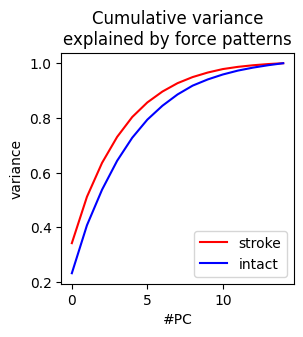

In [25]:
scaler = StandardScaler()
pca = PCA()
var_expl = np.zeros((2, N, 15)) # (groups, n_subj, n_channels)
for d, ds in enumerate(dataset):
    for s, sn in enumerate(tinfo.subj_id.unique()):
        tinfo_s = tinfo[(tinfo.subj_id == sn) & (tinfo.group == ds)]
        X = np.load(os.path.join(gl.baseDir, 'baseline', f'single_finger.pretraining.{ds}.{sn}.npy')) # (trials, time, channels)
        X_r = X.reshape(-1, X.shape[-1])
        X_norm = scaler.fit_transform(X_r)
        pca.fit(X_norm)
        var_expl[d, s] = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(np.cumsum(var_expl[0].mean(axis=0)), color='r', label='stroke')
ax.plot(np.cumsum(var_expl[1].mean(axis=0)), color='b', label='intact')
ax.legend()
ax.set_title('Cumulative variance\nexplained by force patterns')
ax.set_xlabel('#PC')
ax.set_ylabel('variance')

plt.show()